In [1]:
from models import UNETModule
import torch
from torch.utils.data import DataLoader


/usr/local/lib/python3.9/dist-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: libtorch_cuda_cu.so: cannot open shared object file: No such file or directory
  warn(f"Failed to load image Python extension: {e}")


In [2]:
import gc
torch.cuda.empty_cache()
gc.collect()

0

### Water Bodies Dataset

In [3]:
from datasets import WaterBodiesDataset, SimpleWaterBodiesDataset

root = "../water-segmentation-vtx/dataset/"
train_dataset = SimpleWaterBodiesDataset(root, mode="train")
val_dataset = SimpleWaterBodiesDataset(root, mode="val")

print("Train dataset length:", len(train_dataset))
print("Val dataset length:", len(val_dataset))

Train dataset length: 801
Val dataset length: 90


In [4]:
aosjdas = WaterBodiesDataset(root, mode="val")
aosjdas.__getitem__(0)["mask"].shape

(480, 640)

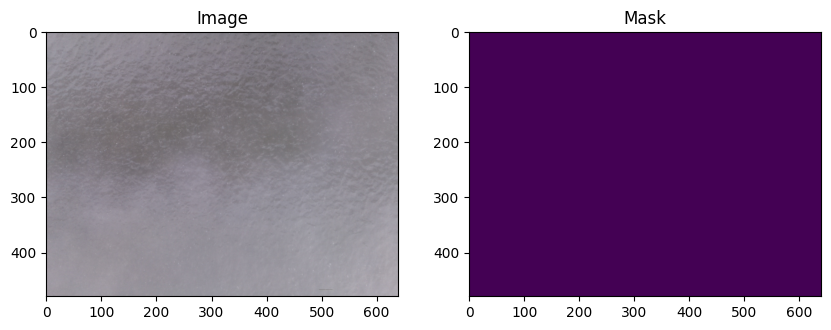


Mask Array:
[[[1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]
  ...
  [1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]]]
(1, 480, 640)


In [5]:
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

example = val_dataset.__getitem__(0)
image_array = example["image"]
mask_array = example["mask"]
image = Image.fromarray(image_array.transpose(1,2,0), 'RGB')
mask = Image.fromarray((np.squeeze(mask_array, axis=0)*255).astype(np.uint8))

fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(image)
axes[0].set_title("Image")
axes[1].imshow(mask)
axes[1].set_title("Mask")
plt.show()

# print("Image Array:")
# print(image_array)
print("\nMask Array:")
print(mask_array)

print(mask_array.shape)


#### Dataloader

In [6]:

n_cpu = os.cpu_count()
train_dataloader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=n_cpu)
valid_dataloader = DataLoader(val_dataset, batch_size=8, shuffle=False, num_workers=n_cpu)

### Training

In [7]:
import torch
import pytorch_lightning as pl
import torchvision
import numpy as np

accelerator = "gpu" if torch.cuda.is_available() else "cpu"

unet_module = UNETModule()

unet_trainer = pl.Trainer(
    max_epochs=10,
    accelerator=accelerator,
    devices=1,
)

unet_trainer.fit(unet_module, train_dataloader, valid_dataloader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type            | Params
---------------------------------------------------
0 | model          | Unet            | 51.5 M
1 | loss_fn        | DiceLoss        | 0     
2 | validation_iou | SegmentationIOU | 0     
3 | training_iou   | SegmentationIOU | 0     
4 | test_iou       | SegmentationIOU | 0     
---------------------------------------------------
51.5 M    Trainable params
0         Non-trainable params
51.5 M    Total params
206.053   Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


In [8]:
logits  = unet_trainer.predict(unet_module, valid_dataloader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

In [9]:
(torch.sigmoid(logits[0]) > 0.5).float().shape

torch.Size([8, 1, 480, 640])

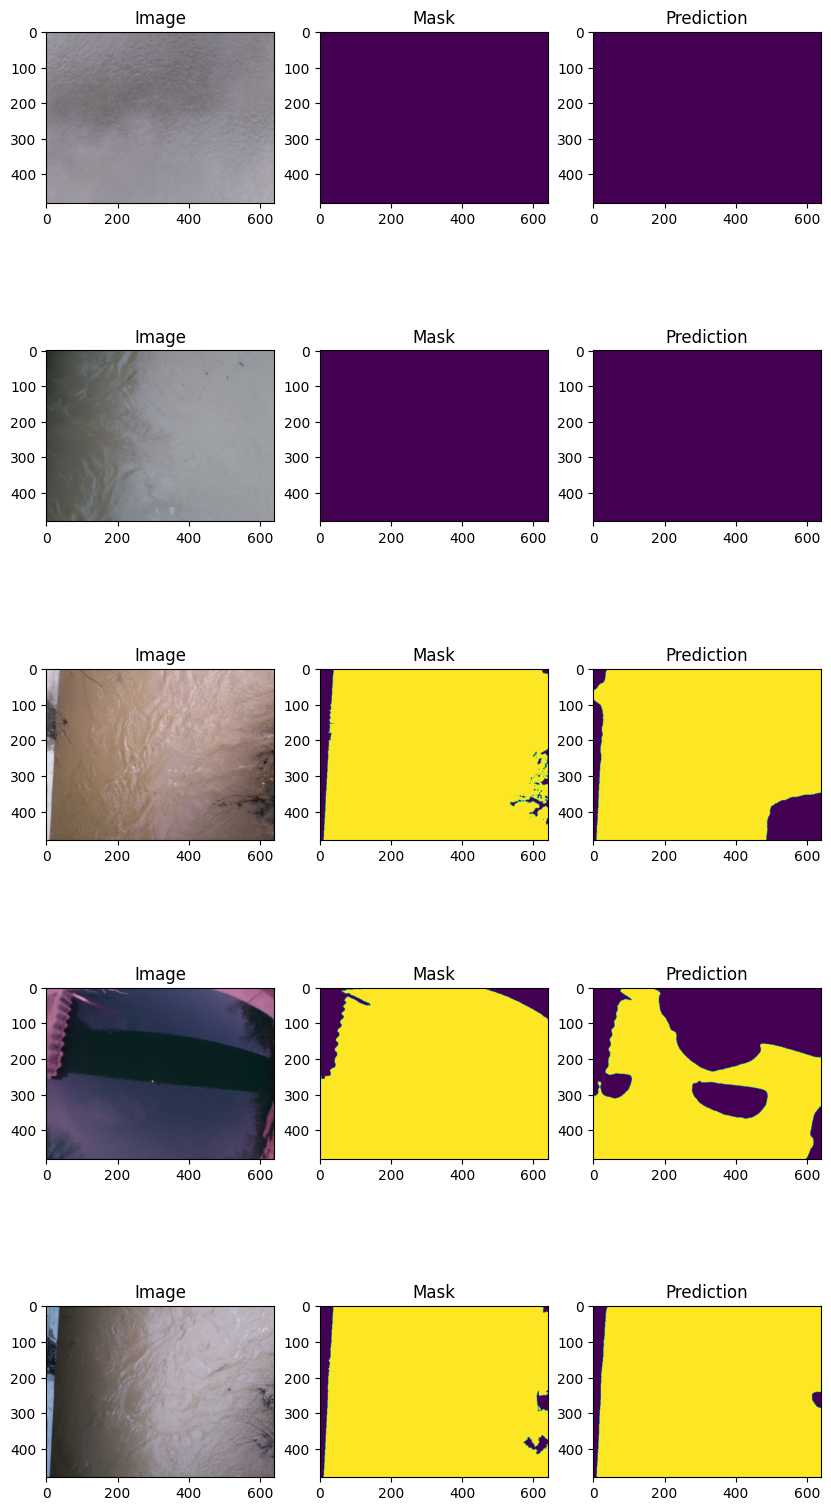

In [10]:
preds = (torch.sigmoid(logits[0]) > 0.5).float()


fig, axes = plt.subplots(5, 3, figsize=(10, 20))
for i in range(5):
    example = val_dataset.__getitem__(i)
    image_array = example["image"]
    mask_array = example["mask"]
    image = Image.fromarray(image_array.transpose(1,2,0), 'RGB')
    mask = Image.fromarray((np.squeeze(mask_array, axis=0)*255).astype(np.uint8))
    prediction = Image.fromarray((np.squeeze(preds[i].cpu().numpy(), axis=0)*255).astype(np.uint8))
    axes[i][0].imshow(image)
    axes[i][0].set_title("Image")
    axes[i][1].imshow(mask)
    axes[i][1].set_title("Mask")
    axes[i][2].imshow(prediction)
    axes[i][2].set_title("Prediction")

